# Pipeline Teórico de Preprocesamiento – WESAD (S10)
Reconocimiento de Patrones 2026-B

Este notebook implementa el pipeline completo de preprocesamiento para el dataset WESAD,
siguiendo las fases teóricas vistas en clase:

1. Descripción de datos
2. Tratamiento de datos incompletos
3. Eliminación de puntos extremos
4. Normalización y discretización

El análisis se realiza **por señal fisiológica**, respetando su estructura y frecuencia.

In [1]:
# Importación de librerías
import os
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import glob
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\frida\AppData\Local\pypoetry\Cache\virtualenvs\recocimiento_de_patrones-H2B1DW3a-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuración de rutas
Se asume que el dataset WESAD ya fue descargado con kagglehub.

In [2]:

# Descargar dataset
path = kagglehub.dataset_download(
    "orvile/wesad-wearable-stress-affect-detection-dataset"
)

print("Path raíz:", path)
print("Contenido raíz:", os.listdir(path))

# Ruta correcta al dataset WESAD
base_path = os.path.join(path, "WESAD")
# Ruta al sujeto S10
s10_path = os.path.join(base_path, "S10")

# Ruta correcta a los datos fisiológicos
s10_data_path = os.path.join(s10_path, "S10_E4_Data")

# Verificar archivos
print("Archivos en S10_D4_Data:")
print(os.listdir(s10_data_path))


Path raíz: C:\Users\frida\.cache\kagglehub\datasets\orvile\wesad-wearable-stress-affect-detection-dataset\versions\1
Contenido raíz: ['WESAD']
Archivos en S10_D4_Data:
['ACC.csv', 'BVP.csv', 'EDA.csv', 'HR.csv', 'IBI.csv', 'info.txt', 'tags.csv', 'TEMP.csv']


## Función general para cargar señales WESAD
Elimina las dos primeras filas (timestamp inicial y frecuencia de muestreo).

In [3]:
def load_signal(file_path, cols=None):
    df = pd.read_csv(file_path, header=None)
    signal = df.iloc[2:]
    signal = signal.astype(float)
    if cols:
        signal.columns = cols
    return signal

## 1. Descripción de datos (por señal)

In [4]:
signals = {}

signals['TEMP'] = load_signal(os.path.join(s10_data_path, "TEMP.csv"), ["TEMP"])
signals['EDA'] = load_signal(os.path.join(s10_data_path, "EDA.csv"), ["EDA"])
signals['BVP'] = load_signal(os.path.join(s10_data_path, "BVP.csv"), ["BVP"])
signals['HR']  = load_signal(os.path.join(s10_data_path, "HR.csv"), ["HR"])
signals['ACC'] = load_signal(os.path.join(s10_data_path, "ACC.csv"), ["ACC_X", "ACC_Y", "ACC_Z"])

for name, df_sig in signals.items():
    print(f"\nSeñal: {name}")
    display(df_sig.describe())


Señal: TEMP


,TEMP
count,27288.000000
mean,33.143370
std,4.382703
min,30.770000
25%,32.250000
50%,33.330000
75%,34.110000
max,382.210000



Señal: EDA


,EDA
count,27288.000000
mean,0.856290
std,0.736143
min,0.000000
25%,0.381194
50%,0.444140
75%,1.044241
max,3.507541



Señal: BVP


,BVP
count,436645.000000
mean,0.000429
std,46.319997
min,-609.230000
25%,-11.910000
50%,2.250000
75%,12.280000
max,779.690000



Señal: HR


,HR
count,6813.000000
mean,90.211493
std,11.318801
min,67.200000
25%,79.520000
50%,91.300000
75%,97.700000
max,132.920000



Señal: ACC


,ACC_X,ACC_Y,ACC_Z
count,218328.000000,218328.000000,218328.000000
mean,41.790480,-7.080457,15.472963
std,18.804473,26.518563,30.140473
min,-108.000000,-128.000000,-106.000000
25%,24.000000,-22.000000,-11.000000
50%,46.000000,-2.000000,11.000000
75%,59.000000,6.000000,49.000000
max,127.000000,94.000000,127.000000


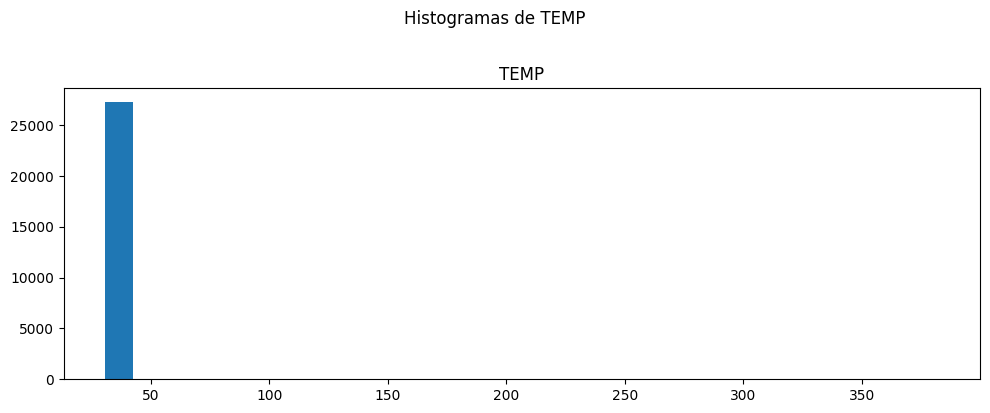

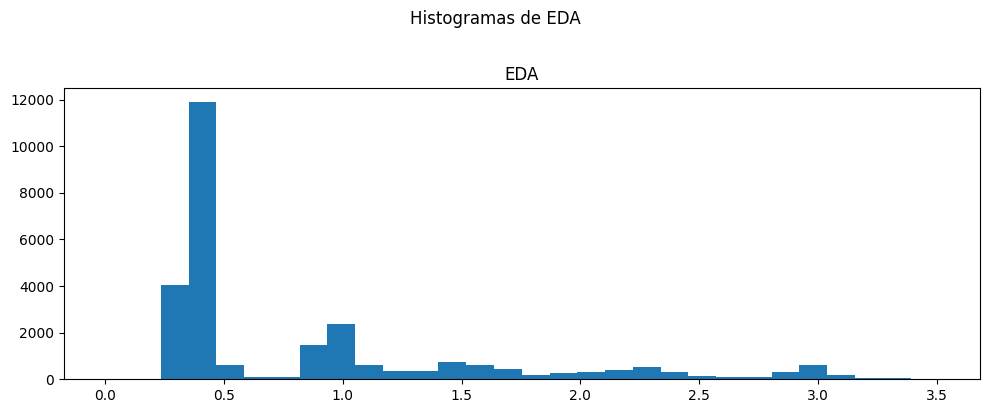

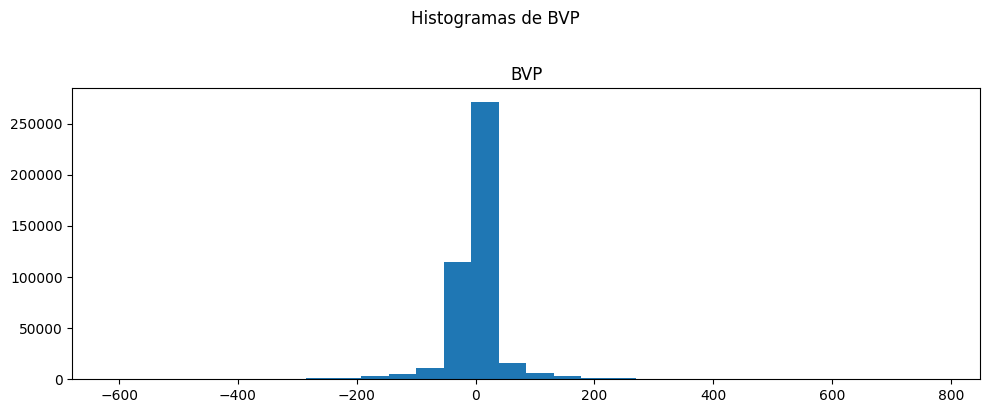

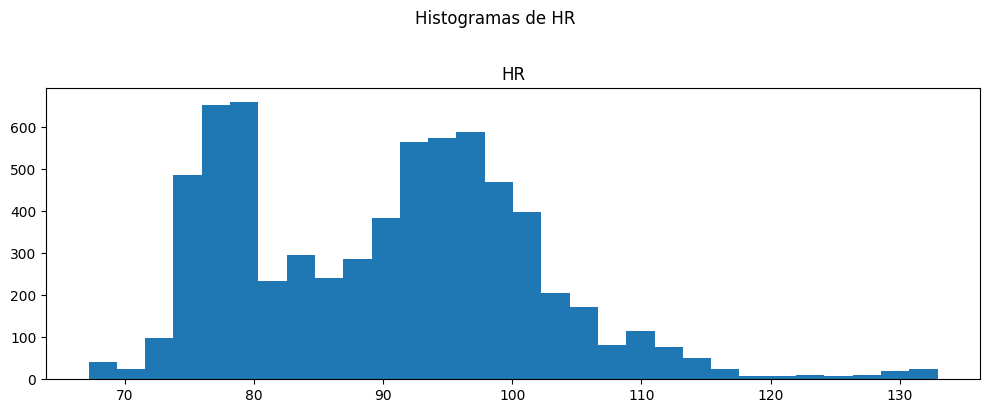

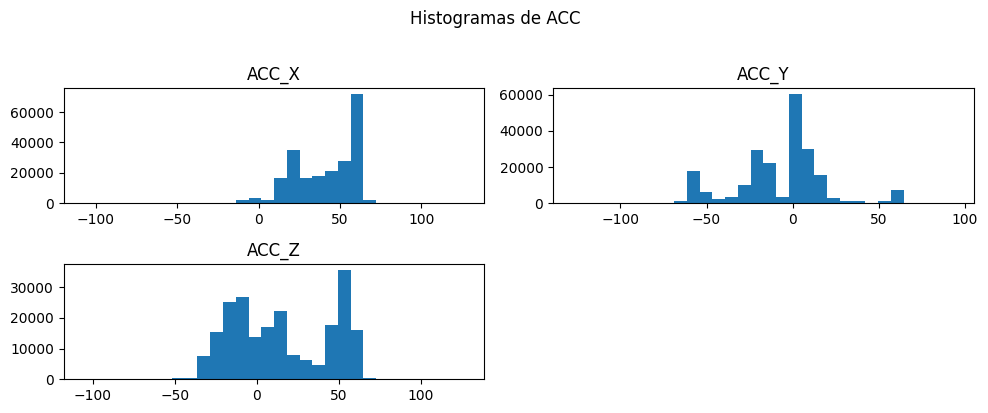

In [5]:
# Histogramas de características numéricas por señal
for name, df_sig in signals.items():
    ax = df_sig.hist(bins=30, figsize=(10, 4), grid=False)
    for a in np.ravel(ax):
        a.set_xlabel("")
    plt.suptitle(f"Histogramas de {name}", y=1.02)
    plt.tight_layout()
    plt.show()

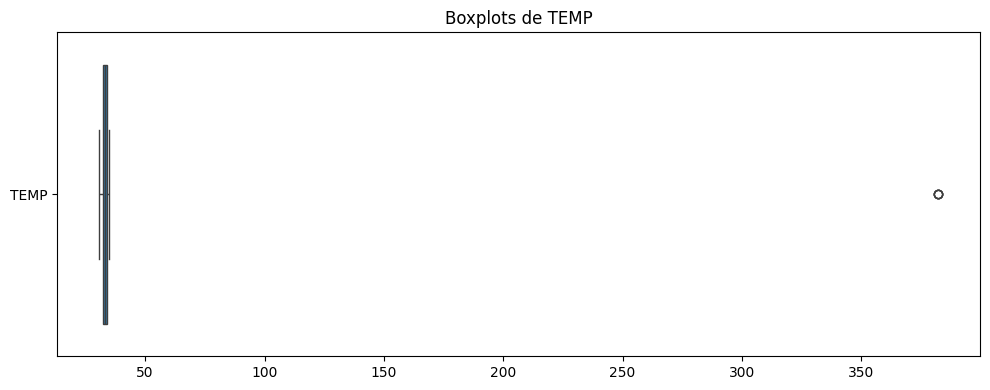

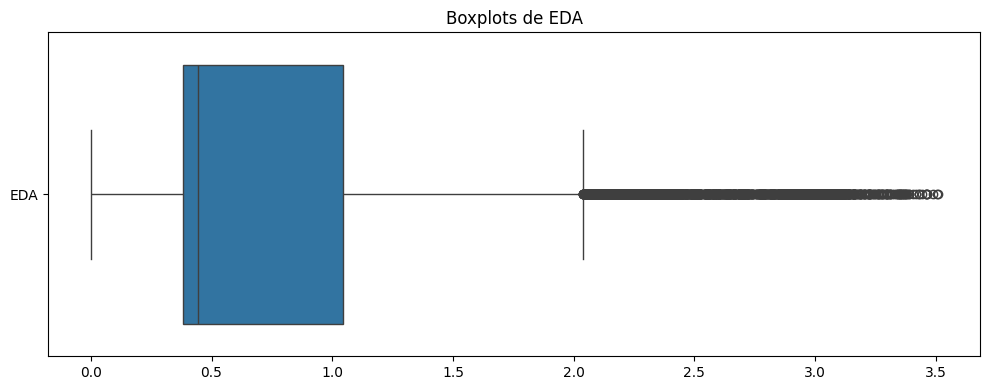

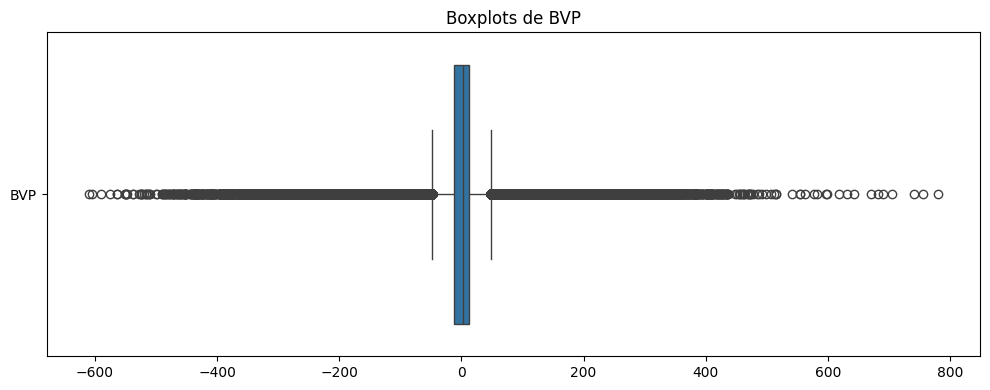

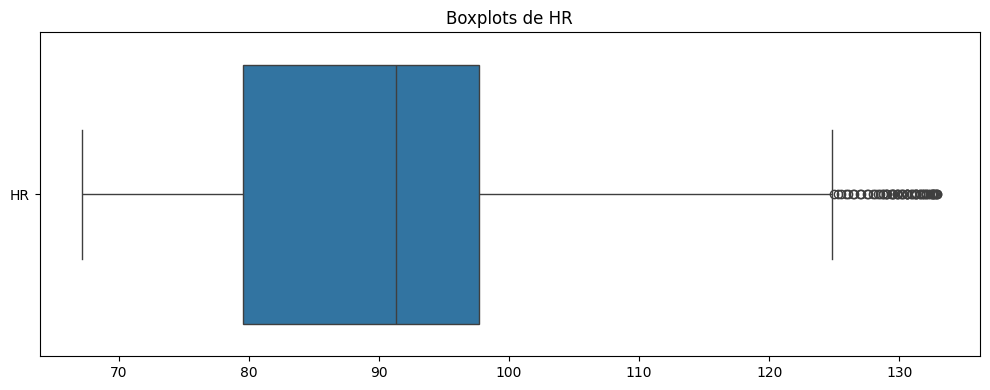

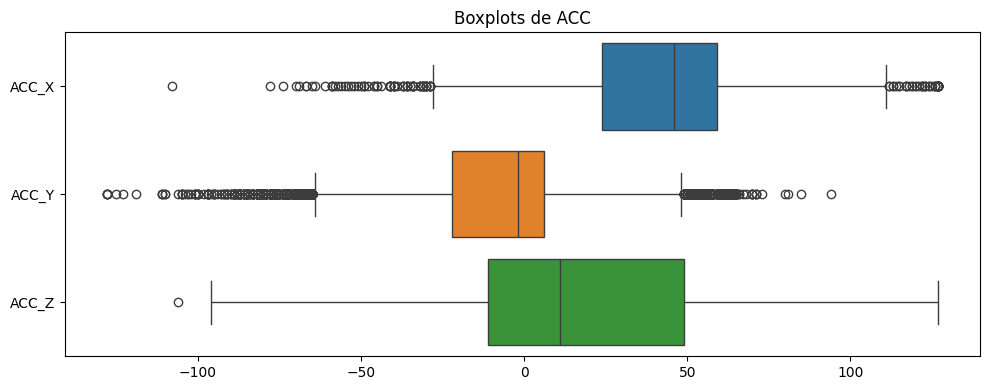

In [6]:
# Boxplots de características numéricas por señal
for name, df_sig in signals.items():
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_sig, orient="h")
    plt.title(f"Boxplots de {name}")
    plt.tight_layout()
    plt.show()

## 2. Tratamiento de datos incompletos
Se imputan valores faltantes con la **media de la señal**, según lo visto en clase.

In [7]:
signals_imputed = {}

for name, df_sig in signals.items():
    df_imp = df_sig.copy()
    for col in df_imp.columns:
        df_imp[col] = df_imp[col].fillna(df_imp[col].mean())
    signals_imputed[name] = df_imp

## 3. Eliminación de puntos extremos
Se utiliza el método IQR (distribuciones no normales).

In [8]:
def remove_outliers_iqr_signal(df):
    df_clean = df.copy()
    for col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

signals_no_outliers = {}

for name, df_sig in signals_imputed.items():
    signals_no_outliers[name] = remove_outliers_iqr_signal(df_sig)

## 4. Normalización (Z-score)
$\hat{x}_{ik} = (x_{ik} - \bar{x}_k) / \sigma_k$

In [9]:
signals_normalized = {}

for name, df_sig in signals_no_outliers.items():
    df_norm = df_sig.copy()
    for col in df_norm.columns:
        mean = df_norm[col].mean()
        std = df_norm[col].std(ddof=1)
        df_norm[col] = (df_norm[col] - mean) / std
    signals_normalized[name] = df_norm

## 5. Discretización de igual amplitud (T = 3)

In [10]:
T = 3
signals_discretized = {}

for name, df_sig in signals_normalized.items():
    df_disc = df_sig.copy()
    for col in df_disc.columns:
        vmin = df_disc[col].min()
        vmax = df_disc[col].max()
        w = (vmax - vmin) / T
        bins = [vmin + i*w for i in range(T+1)]
        df_disc[col + "_disc"] = pd.cut(df_disc[col], bins=bins, labels=[1, 2, 3])
    signals_discretized[name] = df_disc
    
for name, df_disc in signals_discretized.items():
    print(f"\nSeñal: {name}")
    display(df_disc.head())

    
    


Señal: TEMP


,TEMP,TEMP_disc
6,-1.640774,1
7,-1.640774,1
8,-1.640774,1
9,-1.640774,1
10,-1.640774,1



Señal: EDA


,EDA,EDA_disc
2,-1.519819,NaN
3,-0.985006,1
4,-0.839972,1
5,-0.824864,1
6,-0.821843,1



Señal: BVP


,BVP,BVP_disc
2,-0.031262,2
3,-0.031262,2
4,-0.031262,2
5,-0.031262,2
6,-0.031262,2



Señal: HR


,HR,HR_disc
2,-1.755815,1
3,-1.755815,1
4,-1.786520,1
5,-1.732554,1
6,-1.644160,1



Señal: ACC


,ACC_X,ACC_Y,ACC_Z,ACC_X_disc,ACC_Y_disc,ACC_Z_disc
2,-2.194190,0.471236,1.531482,1,2,3
3,-2.194190,0.471236,1.531482,1,2,3
4,-2.194190,0.471236,1.531482,1,2,3
5,-2.136884,0.471236,1.531482,1,2,3
6,-2.194190,0.471236,1.531482,1,2,3


In [11]:
output_root = os.path.join(os.getcwd(), "WESAD_PROCESADO", "S10")

# Crear carpeta si no existe
os.makedirs(output_root, exist_ok=True)

for signal_name, df_norm in signals_normalized.items():
    output_file = os.path.join(
        output_root,
        f"{signal_name}_NORMALIZADA.csv"
    )
    df_norm.to_csv(output_file, index=False)
    print(f"Guardado correctamente en proyecto: {output_file}")


Guardado correctamente en proyecto: c:\Users\frida\Documents\Recocimiento de patrones\notebooks\WESAD_PROCESADO\S10\TEMP_NORMALIZADA.csv
Guardado correctamente en proyecto: c:\Users\frida\Documents\Recocimiento de patrones\notebooks\WESAD_PROCESADO\S10\EDA_NORMALIZADA.csv
Guardado correctamente en proyecto: c:\Users\frida\Documents\Recocimiento de patrones\notebooks\WESAD_PROCESADO\S10\BVP_NORMALIZADA.csv
Guardado correctamente en proyecto: c:\Users\frida\Documents\Recocimiento de patrones\notebooks\WESAD_PROCESADO\S10\HR_NORMALIZADA.csv
Guardado correctamente en proyecto: c:\Users\frida\Documents\Recocimiento de patrones\notebooks\WESAD_PROCESADO\S10\ACC_NORMALIZADA.csv


## Conclusión
El pipeline implementa el preprocesamiento completo del dataset WESAD para el sujeto S10,
respetando la estructura multimodal del dataset y aplicando los métodos teóricos vistos en clase.